In [219]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))

# Importing needed libraries
from matplotlib import pyplot as plt
from ecg2rr import data
import wfdb
from wfdb.io import get_record_list
from wfdb import rdsamp
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.signal import resample_poly


# Now you can import
from ecg2rr import data
import tensorflow
from tensorflow.keras import layers, models, Input
import numpy as np

In [220]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [221]:
# path = 'saved_data/math_functions_single.nc'
import xarray as xr

path = '/nsls2/users/shasko/Repos/ecg2rr/ecg2rr/math_functions_smalldataset.nc'
ds = xr.open_dataset(path, engine="netcdf4")


gaussians = ds["Gaussians"].values
binary = ds["BinaryArr"].values
print(type(binary))
# for j in range(binary.shape[0]):
#     idx = np.where(binary[j] == 1)[0][0] # because there's only 1 "1" we can use [0][0]
#     binary[j][idx - 2] = 1
#     binary[j][idx - 1] = 1
#     binary[j][idx + 1] = 1
#     binary[j][idx + 2] = 1

x = ds["x"].values

<class 'numpy.ndarray'>


In [222]:
import sklearn
from sklearn.model_selection import train_test_split

train_gaussians, test_gaussians, train_binary, test_binary = train_test_split(gaussians, binary, test_size=0.2, shuffle=False)

In [223]:
gauss_signals_train = [signal for signal in train_gaussians]
gauss_signals_test = [signal for signal in test_gaussians]

binary_labels_train = [label for label in train_binary]
binary_labels_test = [label for label in test_binary]

In [224]:
import wfdb
from wfdb.processing import (
    resample_singlechan,
    find_local_peaks,
    correct_peaks,
    normalize_bound
)

In [225]:
def data_generator(signals, labels, win_size, batch_size):
   
    while True:
        X, y = [], []

        while len(X) < batch_size:
            i = np.random.randint(0, len(signals))
            sig = signals[i]
            lbl = labels[i]

            if len(sig) <= win_size + 4:
                continue  # skip short signals

            start = np.random.randint(2, len(sig) - win_size - 2)
            end = start + win_size

            data_win = sig[start:end]
            label_win = lbl[start:end]

            # Pad 1s ±2 samples around every 1 in label_win
            padded_label = label_win.copy()
            ones = np.where(label_win == 1)[0]
            for p in ones:
                for offset in [-2, -1, 1, 2]:
                    if 0 <= p + offset < win_size:
                        padded_label[p + offset] = 1

            # Normalize signal window to (0, 1)
            data_win = normalize_bound(data_win, lb=0, ub=1)

            X.append(data_win)
            y.append(padded_label)

        X = np.array(X).reshape(batch_size, win_size, 1)
        y = np.array(y).reshape(batch_size, win_size, 1).astype(int)

        yield X, y

In [226]:
gen = data_generator(gauss_signals_train, binary_labels_train, win_size=990, batch_size=64)
X_batch, y_batch = next(gen)

In [227]:
n = next(gen)

<class 'tuple'>
2
(64, 990, 1)
(64, 990, 1)


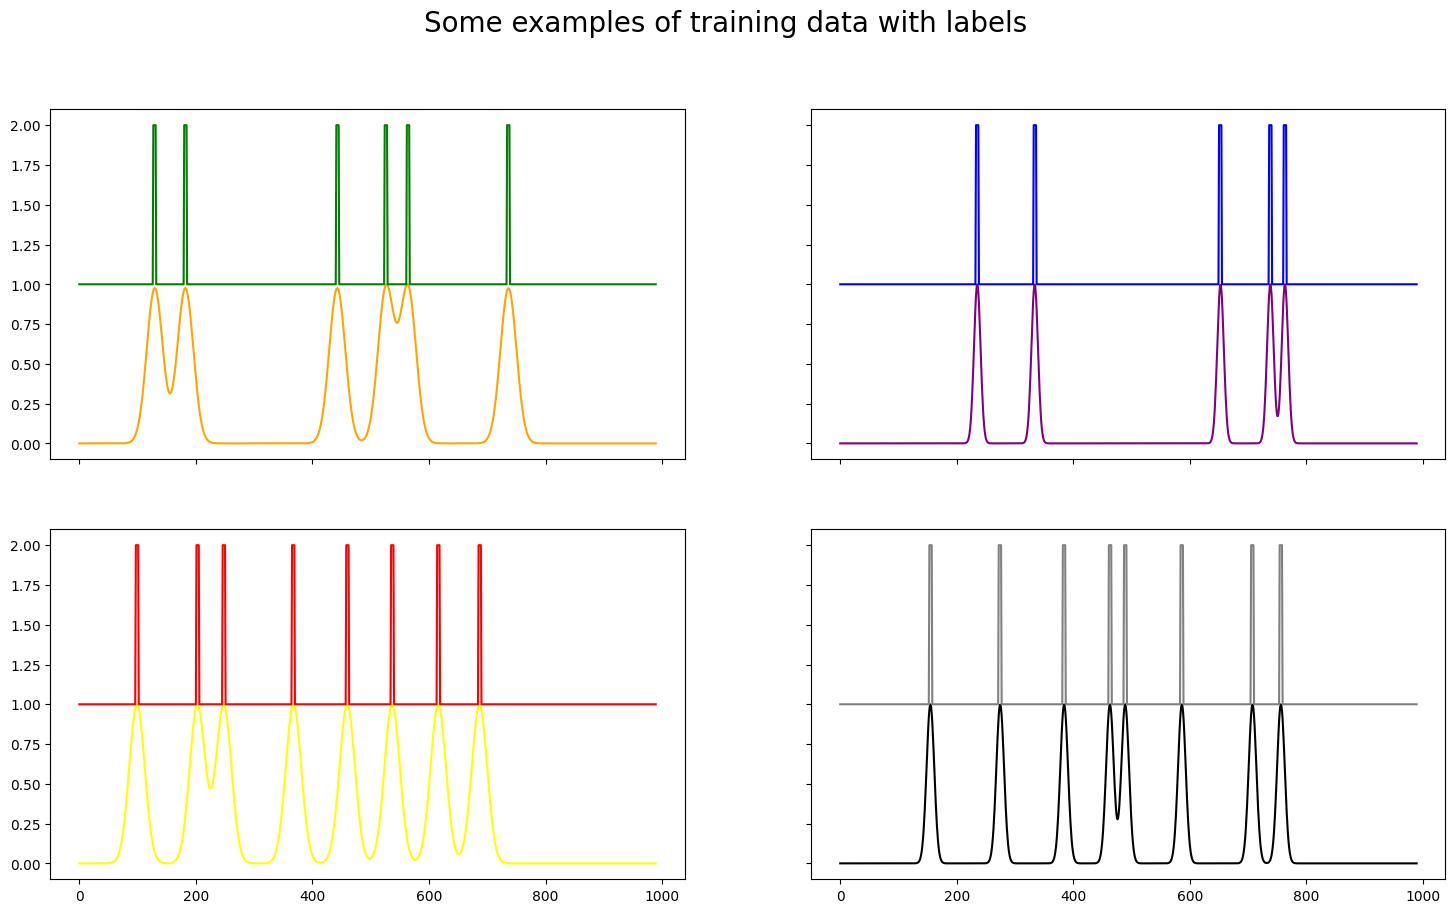

In [228]:

print(type(n))         # likely a tuple
print(len(n))          # 2: probably (inputs, labels)
print(n[0].shape)      # input batch shape
print(n[1].shape)      # label batch shape

# Plot 4 training examples with labels
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10), fig.set_figwidth(18)
fig.suptitle('Some examples of training data with labels', size=20)

# first index refers to whether it's an input or label, so noisy signal is input and peaks are labels
axs[0, 0].plot(n[0][0], color='orange')
axs[0, 0].plot(n[1][0]+1, color='green')

axs[0, 1].plot(n[0][1], color='purple')
axs[0, 1].plot(n[1][1]+1, color='blue')

axs[1, 0].plot(n[0][2], color='yellow')
axs[1, 0].plot(n[1][2]+1, color='red')

axs[1, 1].plot(n[0][3], color='black')
axs[1, 1].plot(n[1][3]+1, color='grey')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [229]:
n_batch, n_timesteps, n_input_dim = 64, 990, 1

model = models.Sequential()
model.add(Input(shape=(n_timesteps, n_input_dim)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


In [230]:
training_gen = data_generator(gauss_signals_train, binary_labels_train, win_size=n_timesteps, batch_size=n_batch)

In [231]:
model.fit(training_gen,
          steps_per_epoch=40,
          epochs=20)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 468ms/step - acc: 0.9026 - loss: 0.5028
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - acc: 0.9650 - loss: 0.1428
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 464ms/step - acc: 0.9647 - loss: 0.0967
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 466ms/step - acc: 0.9757 - loss: 0.0523
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 466ms/step - acc: 0.9899 - loss: 0.0327
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 466ms/step - acc: 0.9936 - loss: 0.0239
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - acc: 0.9954 - loss: 0.0197
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 466ms/step - acc: 0.9962 - loss: 0.0161
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 468ms/step - acc: 0.9959 - loss: 0.0150
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 466ms/step - acc: 0.9969 - loss: 0.0130
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 468ms/step - acc: 0.9969 - loss: 0.0119
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 468ms/step - acc: 0.9971 - loss: 0.0113
Epoch 13/20
4

In [232]:
testing_gen = data_generator(gauss_signals_test, binary_labels_test, win_size=n_timesteps, batch_size=n_batch)

In [233]:
gauss_test, label_test = next(testing_gen)

In [234]:
label_test.shape

(64, 990, 1)

In [235]:
binary_pred = model.predict(gauss_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


In [236]:
binary_pred.shape

(64, 990, 1)

In [270]:
np.where(binary_pred[5] > 1e-2)[0]
#binary_pred[5]
binary_pred[5][750:760]

array([[0.00371126],
       [0.0055958 ],
       [0.00805658],
       [0.0112288 ],
       [0.01452697],
       [0.01481295],
       [0.00899588],
       [0.00306884],
       [0.00101427],
       [0.0006064 ]], dtype=float32)

In [286]:
plt.close('all')

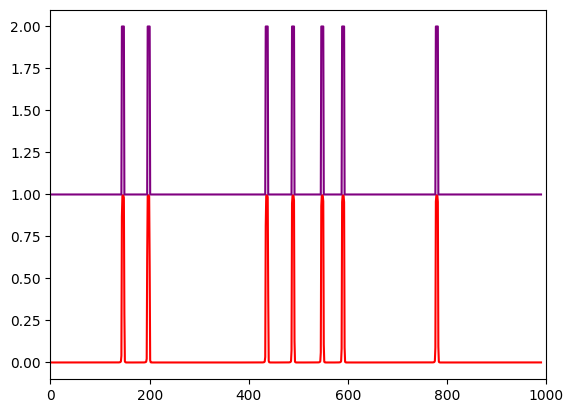

In [ ]:
plt.figure()
for j in range(26,27):
    plt.plot(binary_pred[j], color='red')
    plt.plot(label_test[j] + 1, color='purple')
plt.xlim(0,1000)
plt.show()

In [238]:
binary_pred.shape

(64, 990, 1)